In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/manojaryalgit/nepal-earthquake-mb-data/main/Nepaleqmbdata.csv')

# Convert 'Date and Time' to datetime
df['Date and Time'] = pd.to_datetime(df['Date and Time'], format='%d/%m/%Y %H:%M:%S')

# Sort by date
df = df.sort_values('Date and Time')

# Create new features
df['Days_Since_Last'] = df['Date and Time'].diff().dt.total_seconds() / (24 * 60 * 60)
df['Day_of_Year'] = df['Date and Time'].dt.dayofyear
df['Month'] = df['Date and Time'].dt.month

# Create rolling mean of past 5 events
df['MAG_Rolling_Mean'] = df['MAG'].rolling(window=5).mean()

# Convert columns to numeric, replacing empty strings with NaN
numeric_columns = ['LAT', 'LON', 'DEPTH', 'MAG']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values
df = df.dropna()

# Prepare features and target
features = ['LAT', 'LON', 'DEPTH', 'Days_Since_Last', 'Day_of_Year', 'Month', 'MAG_Rolling_Mean']
target = 'MAG'

X = df[features]
y = df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("Data preprocessing completed.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Data preprocessing completed.
Training set shape: (2308, 1, 7)
Test set shape: (577, 1, 7)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    LSTM(64, input_shape=(1, X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("Model training completed.")

Epoch 1/100


/Users/manojaryal/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.8917 - val_loss: 3.5413
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.6966 - val_loss: 0.5730
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6309 - val_loss: 0.4433
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.5267 - val_loss: 0.3443
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.3901 - val_loss: 0.2803
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 0.3596 - val_loss: 0.2353
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.2717 - val_loss: 0.2144
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.2387 - val_loss: 0.1995
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.2323 - val_loss: 0.1859
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.2157 - val_loss: 0.1810
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.2077 - val_loss: 0.1761
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
Mean Absolute Error: 0.2996398136562037
Root Mean Square Error: 0.4010890841571716
R-squared Score: 0.4172957999118603


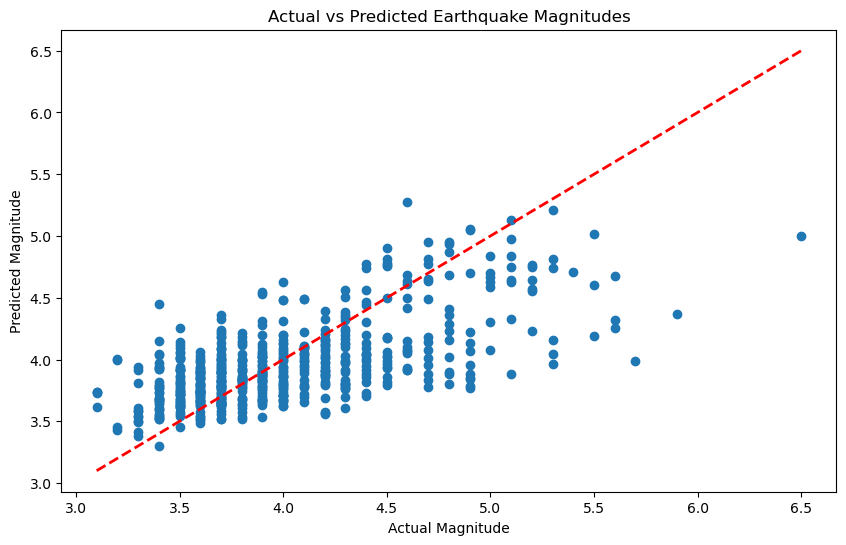

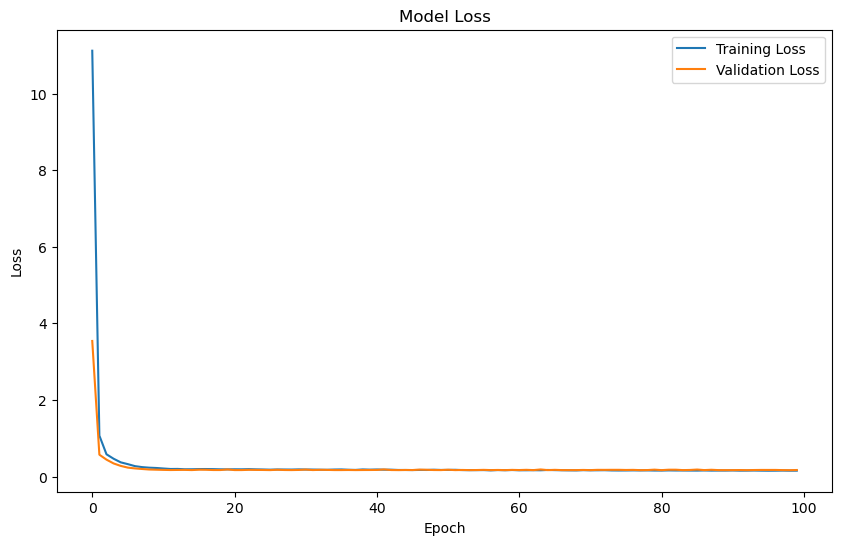

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Square Error: {rmse}")
print(f"R-squared Score: {r2}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Actual vs Predicted Earthquake Magnitudes')
plt.show()

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [4]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Ensure X_scaled and y are numpy arrays
X_scaled = X_scaled.to_numpy() if isinstance(X_scaled, pd.DataFrame) else X_scaled
y = y.to_numpy() if isinstance(y, pd.Series) else y

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled)):
    print(f"Fold {fold + 1}/{n_splits}")
    
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    
    model_clone = clone_model(model)
    model_clone.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    model_clone.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    
    y_pred = model_clone.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    r2_scores.append(r2_score(y_val, y_pred))

print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")

Fold 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Average MAE: 0.2931050235311948
Average RMSE: 0.3929907817233024
Average R-squared: 0.45458584320922724
